This is a script written by Zach Monge, which demonstrates (1) standard collaborative filtering with bias ("shallow learning") and (2) and collaborative filtering with an Embedding Net ("deep learning"). For the data, I used the MovieLens 100K ratings database, which may be downloaded at https://grouplens.org/datasets/movielens/ (download the ml-latest-small.zip). The dataset contains ratings from about 700 users for 9000 movies. For this script I use fastai, which is written on top of PyTorch. I orginally ran this script on Google Cloud Platform with 8 vCPus and 1 NVIDIA Tesla K80 GPU. I would like to thank the fastai library creators for providing many parts of the code included here.

In [1]:
# Importing functions

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *import pandas as pd

# 1. Collaborative filtering w/ bias

In [2]:
# This is using the standard default collaborative filtering that is written in fastai
# Note how we do collaborative filtering with only a few lines of code

# Path to data 
path = '/home/zachm/fastai_data/ml-latest-small/'

# Importing ratings data
ratings = pd.read_csv(f'{path}ratings.csv')

# Getting indices for the samples that will be the validation set
val_idx = get_cv_idxs(len(ratings))

In [3]:
# Putting the data into a dataset that can work easily with fastai
cf=CollabFilterDataset.from_csv(path,'ratings.csv','userId','movieId','rating')

In [4]:
# Now creating the learner, which contains all of the model information

# Number of embedding factors. Can be any number you want. 50 seemed to work well
n_factors = 50
# Putting together the learner
learner = cf.get_learner(n_factors,val_idx,bs=64,opt_fn=optim.Adam)

A Jupyter Widget

 71%|███████▏  | 894/1251 [00:04<00:01, 210.54it/s, loss=4.72]


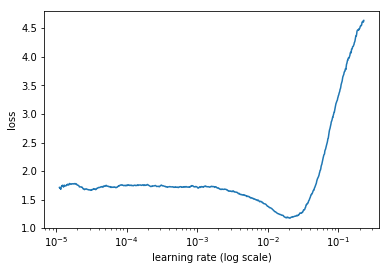

In [5]:
# Before fitting the model can use lr_find to find the learing rate to use. Based upon this result will use 1e-2
learner.lr_find()
learner.sched.plot()

In [6]:
# Now fitting the model
wd=2e-4 # Weight decay

# Fitting. cycle_len & cycle_mult are for running stochastic gradient descent with restarts (SGDR).
learner.fit(1e-2,2,wds=wd,cycle_len=1,cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss                                  
    0      0.812697   0.807057  
    1      0.770731   0.780032                                  
    2      0.588246   0.76591                                   



[0.76591045]

# 2. Collaborative filtering with deep learning

In [7]:
# Now creating the Embedding Net (i.e., collaborative filtering with deep learning). 
# Most of this code is using PyTorch functions, except for get_emb which is from the fastai library. 
# All get_emb does is create an embedding matrix with randomly intialized weights

class EmbeddingNet(nn.Module):
    def __init__(self,n_users,n_movies,n_factors,nh,p1,p2,min_rating,max_rating):
        super().__init__()
        (self.u,self.m) = [get_emb(*o) for o in [(n_users,n_factors),(n_movies,n_factors)]]
        self.lin1 = nn.Linear(n_factors*2,nh)
        self.lin2 = nn.Linear(nh,1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
    
    def forward(self, users, items):
        x = self.drop1(torch.cat([self.u(users),self.m(items)],dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating - min_rating) + min_rating

In [8]:
# This code is straight from the fastai library except I made a slight modification to the get_learner fuction,
# so we can use a custom model (e.g., Embedding Net) with the fastai learner. This will allow us to use special
# fastai functions such as SGDR.
class CollabFilterDataset_custom(Dataset):
    def __init__(self, path, user_col, item_col, ratings):
        self.ratings,self.path = ratings.values.astype(np.float32),path
        self.n = len(ratings)
        (self.users,self.user2idx,self.user_col,self.n_users) = self.proc_col(user_col)
        (self.items,self.item2idx,self.item_col,self.n_items) = self.proc_col(item_col)
        self.min_score,self.max_score = min(ratings),max(ratings)
        self.cols = [self.user_col,self.item_col,self.ratings]

    @classmethod
    def from_data_frame(cls, path, df, user_name, item_name, rating_name):
        return cls(path, df[user_name], df[item_name], df[rating_name])

    @classmethod
    def from_csv(cls, path, csv, user_name, item_name, rating_name):
        df = pd.read_csv(os.path.join(path,csv))
        return cls.from_data_frame(path, df, user_name, item_name, rating_name)

    def proc_col(self,col):
        uniq = col.unique()
        name2idx = {o:i for i,o in enumerate(uniq)}
        return (uniq, name2idx, np.array([name2idx[x] for x in col]), len(uniq))

    def __len__(self): return self.n
    def __getitem__(self, idx): return [o[idx] for o in self.cols]

    def get_data(self, val_idxs, bs):
        val, trn = zip(*split_by_idx(val_idxs, *self.cols))
        return ColumnarModelData(self.path, PassthruDataset(*trn), PassthruDataset(*val), bs)

    def get_model(self, n_factors):
        model = EmbeddingDotBias(n_factors, self.n_users, self.n_items, self.min_score, self.max_score)
        return CollabFilterModel(to_gpu(model))

    def get_learner(self, model, val_idxs, bs, **kwargs):
        return CollabFilterLearner(self.get_data(val_idxs, bs), model, **kwargs)


In [9]:
# Path to data 
path = '/home/zachm/fastai_data/ml-latest-small/'

# Importing ratings data
ratings = pd.read_csv(f'{path}ratings.csv')

# Getting indices for the samples that will be the validation set
val_idx = get_cv_idxs(len(ratings))

# Number of users
n_users = int(ratings.userId.nunique())

# Number of movies
n_movies = int(ratings.movieId.nunique())

# Minimum and maxium rating
min_rating, max_rating = ratings.rating.min(),ratings.rating.max()

In [10]:
# Putting the data into a dataset that can work easily with fastai
data = CollabFilterDataset_custom.from_csv(path,'ratings.csv','userId','movieId','rating')

In [11]:
# Creating the model. For EmbeddingNet, need to sepcify number of users, number of movies, embedding factor size,
# size of hidden layer, first drop out, second drop out, minimum rating, and maximum rating
model_net = EmbeddingNet(n_users,n_movies,50,10,0.05,0.45,min_rating,max_rating)

#Putting the model onto the GPU
model_net = CollabFilterModel(to_gpu(model_net))

In [12]:
# Putting together the learner
net_learner=data.get_learner(model_net,val_idxs=val_idx,bs=64,opt_fn=optim.Adam)

A Jupyter Widget

epoch      trn_loss   val_loss                                 
    0      1.847744   2.277648  



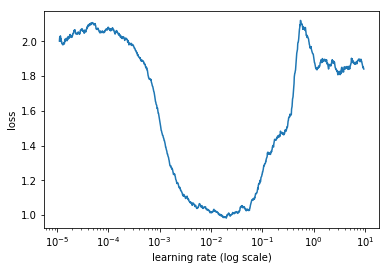

In [13]:
# Before fitting the model can use lr_find to find the learing rate to use. Based upon this result will use 1e-3
net_learner.lr_find()
net_learner.sched.plot()

In [14]:
# Now fitting the model
wd = 1e-5 # Weight decay
# Fitting. cycle_len & cycle_mult are for running stochastic gradient descent with restarts (SGDR).
net_learner.fit(1e-3,2,wds=wd,cycle_len=1,cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss                                  
    0      0.869109   0.82189   
    1      0.784807   0.788799                                  
    2      0.810858   0.784595                                  



[0.78459519]